# 📘 Data Merging & Cleaning – Yousra Descriptive Stats Notebook

This notebook loads the original project datasets (sales, weather, kiwo event),  
cleans and standardizes the date format, merges them using a full outer join,  
and performs descriptive statistics, missing value inspection, and prepares the  
data for further feature engineering and modeling.

The goal is to:
1. Combine **all available data** on matching dates  
2. Perform a clear descriptive exploration  
3. Detect and handle missing values  
4. Produce a clean dataset ready for analysis  


In [1]:
import pandas as pd
import numpy as np

# Load data from your project folder
df_kiwo = pd.read_csv("../data/kiwo.csv")
df_weather = pd.read_csv("../data/wetter.csv")
df_sales = pd.read_csv("../data/umsatzdaten_gekuerzt.csv")

df_kiwo.head(), df_weather.head(), df_sales.head()
#print number of rows for each dataframe
print(f"Kiwo Data Rows: {len(df_kiwo)}")
print(f"Weather Data Rows: {len(df_weather)}")
print(f"sales Data Rows: {len(df_sales)}")

Kiwo Data Rows: 72
Weather Data Rows: 2601
sales Data Rows: 9334


In [2]:
# Convert 'Datum' to proper datetime format and drop invalid rows
for df in (df_kiwo, df_weather, df_sales):
    df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce").dt.normalize()
    df.dropna(subset=["Datum"], inplace=True)

    # Drop duplicate date columns if exist
    if "date" in df.columns:
        df.drop(columns=["date"], inplace=True)

df_kiwo.info(), df_weather.info(), df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datum        72 non-null     datetime64[ns]
 1   KielerWoche  72 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                2601 non-null   datetime64[ns]
 1   Bewoelkung           2591 non-null   float64       
 2   Temperatur           2601 non-null   float64       
 3   Windgeschwindigkeit  2601 non-null   int64         
 4   Wettercode           1932 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 101.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 

(None, None, None)

In [3]:
# Adding suffixes helps avoid confusion during merging

df_kiwo = df_kiwo.add_suffix("_kiwo")
df_kiwo.rename(columns={"Datum_kiwo": "Datum"}, inplace=True)

df_weather = df_weather.add_suffix("_weather")
df_weather.rename(columns={"Datum_weather": "Datum"}, inplace=True)


df_sales = df_sales.add_suffix("_umsatz")
df_sales.rename(columns={"Datum_umsatz": "Datum"}, inplace=True)

#df_umsatz["umsatz_rolling7"] = (
#    df_umsatz["Umsatz_umsatz"].rolling(window=7, min_periods=1).mean()
#)


In [ ]:
# print start and end dates for each dataframe
for name, df in [("Kiwo", df_kiwo), ("Weather", df_weather), ("Sales", df_sales)]:
    print(
        f"{name} Data: Start Date = {df['Datum'].min().date()}, End Date = {df['Datum'].max().date()}"
    ) 

Weather Data: Start Date = 2012-01-01, End Date = 2019-08-01
Sales Data: Start Date = 2013-07-01, End Date = 2018-07-31


In [ ]:
# generate descriptive statistics for each dataframe
for name, df in [("Weather", df_weather), ("Sales", df_sales),("Kiwo", df_kiwo)]:
    print(f"\nDescriptive Statistics for {name} Data:")
    print(df.describe(include="all"))

display(df_sales.isna().sum(), df_weather.isna().sum(), df_kiwo.isna().sum())


Descriptive Statistics for Weather Data:
                               Datum  Bewoelkung_weather  Temperatur_weather  \
count                           2601         2591.000000         2601.000000   
mean   2015-12-07 00:08:18.269896192            4.805866           12.099586   
min              2012-01-01 00:00:00            0.000000          -10.250000   
25%              2014-03-14 00:00:00            3.000000            6.512500   
50%              2015-12-24 00:00:00            6.000000           12.000000   
75%              2017-10-07 00:00:00            7.000000           17.825000   
max              2019-08-01 00:00:00            8.000000           32.671428   
std                              NaN            2.578299            7.174357   

       Windgeschwindigkeit_weather  Wettercode_weather  
count                  2601.000000         1932.000000  
mean                     11.191080           37.484472  
min                       3.000000            0.000000  
25%      

id_umsatz             0
Datum                 0
Warengruppe_umsatz    0
Umsatz_umsatz         0
dtype: int64

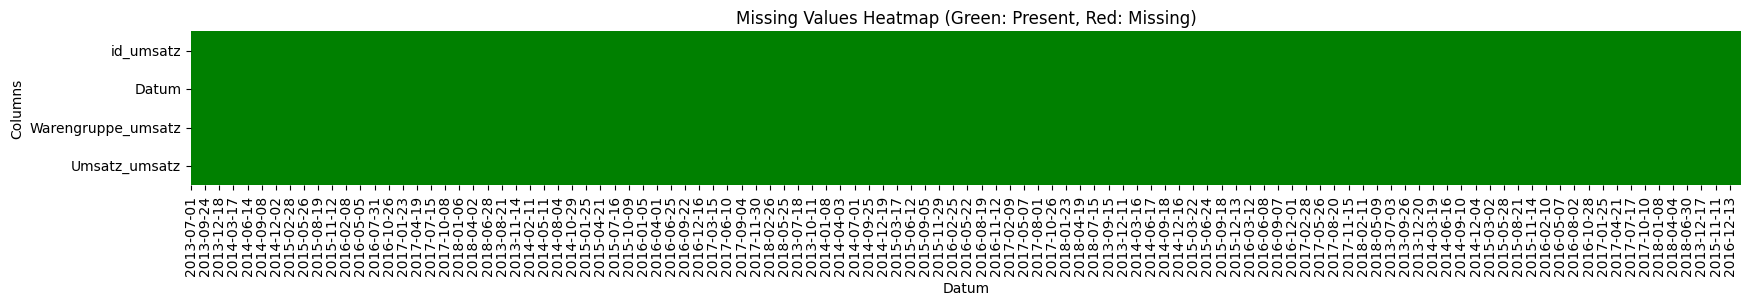

In [19]:


import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is the DataFrame to visualize missing values for
# Create a boolean DataFrame where True (missing) is 1, False (present) is 0
missing_matrix = df_sales.isnull().astype(int)
missing_matrix.set_index(df_sales['Datum'], inplace=True)
missing_matrix.index = missing_matrix.index.date
# Transpose so rows are columns, columns are data rows (horizontal bars)
plt.figure(figsize=(20, len(missing_matrix.columns) * 0.5))  # Adjust height based on number of columns
sns.heatmap(missing_matrix.T, cbar=False, cmap=['green', 'red'], linewidths=0, linecolor='white')
plt.title('Missing Values Heatmap (Green: Present, Red: Missing)')
plt.xlabel('Datum')
plt.ylabel('Columns')
plt.show()

In [4]:
merged_df = (
    df_kiwo
    .merge(df_weather, on="Datum", how="outer")
    .merge(df_sales, on="Datum", how="outer")
)

display(merged_df.shape)
display(merged_df.head())
display(merged_df.tail())


(10119, 9)

,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Wettercode_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz
0,2012-01-01,NaN,8.0,9.8250,14.0,58.0,NaN,NaN,NaN
1,2012-01-02,NaN,7.0,7.4375,12.0,NaN,NaN,NaN,NaN
2,2012-01-03,NaN,8.0,5.5375,18.0,63.0,NaN,NaN,NaN
3,2012-01-04,NaN,4.0,5.6875,19.0,80.0,NaN,NaN,NaN
4,2012-01-05,NaN,6.0,5.3000,23.0,80.0,NaN,NaN,NaN


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Wettercode_weather,id_umsatz,Warengruppe_umsatz,Umsatz_umsatz
10114,2019-07-28,NaN,3.0,23.3500,14.0,5.0,NaN,NaN,NaN
10115,2019-07-29,NaN,6.0,25.2500,7.0,61.0,NaN,NaN,NaN
10116,2019-07-30,NaN,7.0,20.7375,8.0,61.0,NaN,NaN,NaN
10117,2019-07-31,NaN,6.0,20.4500,7.0,61.0,NaN,NaN,NaN
10118,2019-08-01,NaN,5.0,21.0625,9.0,61.0,NaN,NaN,NaN


In [ ]:
# Numeric summary
merged_df.describe()

# For all columns (including categorical)
merged_df.describe(include="all")


In [ ]:
missing_count = merged_df.isna().sum()
missing_percent = (merged_df.isna().sum() / len(merged_df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing_count,
    "Missing %": missing_percent
})

missing_df


### ✔️ Missing Value Strategy

**Umsatz (Sales):**
- Missing values mean the day has **no sales** or is **outside the bakery event period**.
- These rows should be **removed**, not imputed.

**Weather Variables:**
- Weather data may be missing because not all dates have weather records.
- Fill missing values using interpolation (numerical)  
  and assign -1 for Wettercode to indicate “unknown weather”.

**Kiwo Event Flag:**
- If missing → fill with 0 (day outside event).


In [ ]:
clean_df = merged_df.copy()

# Remove rows where sales are missing
clean_df = clean_df.dropna(subset=["Umsatz_umsatz"])

# Fill missing Wettercode with category -1
if "Wettercode_weather" in clean_df.columns:
    clean_df["Wettercode_weather"] = clean_df["Wettercode_weather"].fillna(-1)

# Interpolate numerical weather values
for col in clean_df.columns:
    if ("_weather" in col) and (clean_df[col].dtype in ["float64", "int64"]):
        clean_df[col] = clean_df[col].interpolate()

clean_df.isna().sum()


In [ ]:
clean_df["KielerWoche_kiwo"] = clean_df["KielerWoche_kiwo"].fillna(0)


In [ ]:
clean_df.isna().sum()


In [ ]:
#drop wettercode_weather column
df_no_weather_code = clean_df.drop(columns=["Wettercode_weather"])
df_no_weather_code.sample(5)


## Adding extra columns

In [ ]:
df_no_weather_code['Datum'] = pd.to_datetime(df_no_weather_code['Datum'], errors='coerce').dt.normalize()
n_invalid = df_no_weather_code['Datum'].isna().sum()
if n_invalid > 0:
    print(f"Warning: {n_invalid} rows have invalid 'Datum' and will have NaT in day columns. Sample:")
    display(df_no_weather_code[df_no_weather_code['Datum'].isna()].head())

# Create integer and name columns for day of week
df_no_weather_code['day_of_week'] = df_no_weather_code['Datum'].dt.weekday  # Monday=0 .. Sunday=6
df_no_weather_code['day'] = df_no_weather_code['Datum'].dt.day_name()

# Optional: make 'day' categorical ordered Monday..Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_no_weather_code['day'] = pd.Categorical(df_no_weather_code['day'], categories=ordered_days, ordered=True)

print("\nCounts per weekday:")
print(df_no_weather_code['day'].value_counts().sort_index())
df_no_weather_code.sample(5)

### Adding more weather data from meteo archive api

In [ ]:
import requests
from datetime import datetime, date, timedelta
import time
from typing import Union, Iterable, Dict, List
import pandas as pd
import numpy as np

# Simple in-memory cache for API responses
try:
    _OPEN_METEO_CACHE
except NameError:
    _OPEN_METEO_CACHE: Dict[str, Dict[str, float]] = {}

def _iso_date(d: Union[str, date, datetime]) -> str:
    if isinstance(d, str):
        return datetime.fromisoformat(d).date().isoformat()
    if isinstance(d, datetime):
        return d.date().isoformat()
    return d.isoformat()

def fetch_open_meteo_daily_range(
    start_date: Union[str, date, datetime],
    end_date: Union[str, date, datetime],
    latitude: float = 54.3233,
    longitude: float = 10.1228,
    timezone: str = "Europe/Berlin",
    daily_vars: List[str] = None,
    max_retries: int = 3,
    timeout: float = 15.0,
    use_cache: bool = True
) -> pd.DataFrame:
    """
    Fetch daily historical variables from Open-Meteo archive API for a given inclusive date range.
    By default uses Kiel coordinates (lat=54.3233, lon=10.1228).
    daily_vars example: ['precipitation_hours', 'sunshine_duration', 'rain_sum']
    Returns a pandas.DataFrame indexed by date (datetime.date) with columns named after daily_vars.
    """
    if daily_vars is None:
        daily_vars = ['precipitation_hours', 'sunshine_duration', 'rain_sum']

    start_iso = _iso_date(start_date)
    end_iso = _iso_date(end_date)
    start_dt = datetime.fromisoformat(start_iso).date()
    end_dt = datetime.fromisoformat(end_iso).date()
    if end_dt < start_dt:
        raise ValueError("end_date must be >= start_date")

    # Build cache key based on parameters and requested range
    key = f"{latitude:.6f}_{longitude:.6f}_{start_iso}_{end_iso}_{','.join(daily_vars)}_{timezone}"
    if use_cache and key in _OPEN_METEO_CACHE:
        df = _OPEN_METEO_CACHE[key].copy()
        return df

    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_iso,
        "end_date": end_iso,
        "daily": ",".join(daily_vars),
        "timezone": timezone
    }

    last_exc = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(base_url, params=params, timeout=timeout)
            r.raise_for_status()
            data = r.json()
            daily = data.get("daily", {})
            times = daily.get("time", []) or []
            if not times:
                raise ValueError("No 'time' in API response daily block.")
            results = {"date": pd.to_datetime(times).date}
            for v in daily_vars:
                vals = daily.get(v, None)
                if vals is None:
                    # If a requested variable is missing, fill with NaN
                    results[v] = [np.nan] * len(times)
                else:
                    # Convert to numeric (floats), keep NaN if parsing fails
                    results[v] = [float(x) if x is not None else np.nan for x in vals]
            df = pd.DataFrame(results, index=pd.to_datetime(times).date)
            df.index.name = "date"
            df = df[[v for v in daily_vars]]  # ensure column order
            if use_cache:
                _OPEN_METEO_CACHE[key] = df.copy()
            return df
        except Exception as e:
            last_exc = e
            if attempt < max_retries:
                time.sleep(0.5 * attempt)
                continue
            raise RuntimeError(f"Failed fetching Open-Meteo archive: {e}") from e


In [ ]:
min_date = df_no_weather_code['Datum'].min()
max_date = df_no_weather_code['Datum'].max()
##min_date = "2013-07-01"
##max_date = "2014-07-30"
print (f"Fetching weather data from {min_date} to {max_date}...")
lat_kiel, lon_kiel = 54.3233, 10.1228
daily_vars = ['precipitation_hours', 'sunshine_duration', 'rain_sum','temperature_2m_mean']
df_extra_weather = fetch_open_meteo_daily_range(min_date, max_date, latitude=lat_kiel, longitude=lon_kiel, daily_vars=daily_vars)
# print columns of df_extended_weather


In [ ]:
df_extra_weather['sunshine_hours'] = df_extra_weather['sunshine_duration'] / 3600.0
#df_extended_weather.head()

# print row count for df_extended_weather and df_no_weather_code
print(f"Extended Weather Data Rows: {len(df_extra_weather)}")
print(f"Sales Data Rows: {len(df_no_weather_code)}")


### Extended Data Frames
Its with extra weather data from open meteo api: df_merged_extended_weather
with rolling 7 day average as well for umsatz

In [ ]:
df_extra_weather.index = pd.to_datetime(df_extra_weather.index)
df_merged_extended_weather = df_no_weather_code.merge(
    df_extra_weather,
    left_on='Datum',
    right_index=True,
    how='left'
)

print(f"Merged DataFrame Rows: {len(df_merged_extended_weather)}")
print(f"Merged DataFrame Shape: {df_merged_extended_weather.shape}")

df_merged_extended_weather = df_merged_extended_weather.dropna(subset=["id_umsatz"])
df_merged_extended_weather["id_umsatz"] = df_merged_extended_weather["id_umsatz"].astype("int64")
df_merged_extended_weather = df_merged_extended_weather.dropna(subset=["KielerWoche_kiwo"])
df_merged_extended_weather["KielerWoche_kiwo"] = df_merged_extended_weather["KielerWoche_kiwo"].astype("int64")

df_merged_extended_weather.head()

# Testing Regression

In [ ]:
df_merged_extended_weather.tail()

#show only columns Datum,temperature_weather, temperature_2m_mean
#df_merged_extended_weather[['Datum', 'Temperatur_weather', 'temperature_2m_mean']].sample(10)

#calculate sample mean between temperature_weather and temperature_2m_mean
#df_merged_extended_weather['temperature_mean'] = df_merged_extended_weather[['Temperatur_weather', 'temperature_2m_mean']].mean(axis=1)
#df_merged_extended_weather['temperature_median'] = df_merged_extended_weather[['Temperatur_weather', 'temperature_2m_mean']].median(axis=1)
#df_merged_extended_weather[['Datum', 'Temperatur_weather', 'temperature_2m_mean','temperature_median','temperature_mean']].sample(10)

In [ ]:
import scipy.stats as stats
import seaborn as sns
# Testing Regression
reg_cols=['Umsatz_umsatz','umsatz_rolling7','KielerWoche_kiwo','Bewoelkung_weather', 'rain_sum', 'sunshine_hours','Temperatur_weather','Windgeschwindigkeit_weather','precipitation_hours','day_of_week']
sns.pairplot(df_merged_extended_weather[reg_cols].dropna())
df_merged_extended_weather[reg_cols].corr()

In [ ]:
import statsmodels.formula.api as smf

# Example regression formula (adjust as needed)
formula = "Umsatz_umsatz ~  Temperatur_weather + Bewoelkung_weather + sunshine_hours  + C(Warengruppe_umsatz)"

# Drop rows with missing values in the regression columns
regression_df = df_merged_extended_weather.dropna(subset=[
    "Umsatz_umsatz", "Bewoelkung_weather", "rain_sum", "sunshine_hours","KielerWoche_kiwo",
    "Temperatur_weather", "Windgeschwindigkeit_weather", "precipitation_hours", "day_of_week","Warengruppe_umsatz"
])

# Fit the model
model = smf.ols(formula, data=regression_df).fit()

# Show summary
display(model.summary())

display(regression_df.head())



# Merging test data from test csv


In [ ]:
# Read test.csv into testdf
df_test = pd.read_csv("data/test.csv")

# Quick checks
print("Shape:", df_test.shape)
display(df_test.head())
display(df_test.tail())

In [ ]:
## add weather Temperatur_weather from df_weather
df_test['Datum'] = pd.to_datetime(df_test['Datum'], errors='coerce').dt.normalize()
df_weather['Datum'] = pd.to_datetime(df_weather['Datum'], errors='coerce').dt.normalize()


# Left-join temperature from df_weather onto the test DataFrame (keep all test rows)
df_test_weather = df_test.merge(
    df_weather[['Datum', 'Temperatur_weather', 'Bewoelkung_weather']],
    on='Datum',
    how='left'
)

# now adding day_of_week column
df_test_weather['day_of_week'] = df_test_weather['Datum'].dt.weekday

# filling sunshine_hours from meteo api
test_min_date = df_test_weather['Datum'].min()
test_max_date = df_test_weather['Datum'].max()
print (f"Fetching weather data from {test_min_date} to {test_max_date}...")
lat_kiel, lon_kiel = 54.3233, 10.1228
daily_vars = ['sunshine_duration']
df_sunshine_date = fetch_open_meteo_daily_range(test_min_date, test_max_date, daily_vars=daily_vars) #defaults to kiel lat/lon
df_sunshine_date['sunshine_hours'] = df_sunshine_date['sunshine_duration'] / 3600.0

# rename df_sunshine_date column date to Datum for merging
# drop sunshine_duration column
df_sunshine_date.drop(columns=['sunshine_duration'],inplace=True)
df_sunshine_date = df_sunshine_date.rename_axis('Datum').reset_index()

# convert Datum to type datetime
df_sunshine_date['Datum'] = pd.to_datetime(df_sunshine_date['Datum'], errors='coerce').dt.normalize()
display(df_sunshine_date.head())

# merge sunshine_hours into df_test_weather
df_test_weather = df_test_weather.merge(
    df_sunshine_date[['Datum', 'sunshine_hours']],
    on='Datum',
    how='left'
)

#print shape of df_test_weather
print("Shape after merging sunshine_hours:", df_test_weather.shape)

# merge kiwo data into df_test_weather
df_test_weather = df_test_weather.merge(
    df_kiwo[['Datum', 'KielerWoche_kiwo']],
    on='Datum',
    how='left'
)

print("Shape after merging kiwo data:", df_test_weather.shape)



# Quick sanity checks
print("Shape:", df_test_weather.shape)
print("Missing Temperatur_weather:", df_test_weather['Temperatur_weather'].isna().sum())
#check missing sunshine_hours
print("Missing sunshine_hours:", df_test_weather['sunshine_hours'].isna().sum())
#check missing Bewoelkung_weather
print("Missing Bewoelkung_weather:", df_test_weather['Bewoelkung_weather'].isna().sum())
#check missing KielerWoche_kiwo
print("Missing KielerWoche_kiwo:", df_test_weather['KielerWoche_kiwo'].isna().sum())

df_test_weather['KielerWoche_kiwo'] = df_test_weather['KielerWoche_kiwo'].fillna(0)

display(df_test_weather.head())
display(df_test_weather.tail())
# display 10 sample where kielerwoche_kiwo is 1
display(df_test_weather[df_test_weather['KielerWoche_kiwo'] == 1].sample(10))



In [ ]:
## interpolating missing Temperatur_weather
df_test_weather['Temperatur_weather'] = df_test_weather['Temperatur_weather'].interpolate()

## interpolate Bewoelkung_weather
df_test_weather['Bewoelkung_weather'] = df_test_weather['Bewoelkung_weather'].interpolate()

#15.0
#NaN
#17.0
# interpolation should fill the NaN with 16.0

print("Missing Temperatur_weather:", df_test_weather['Temperatur_weather'].isna().sum())
print("Missing Bewoelkung_weather:", df_test_weather['Bewoelkung_weather'].isna().sum())



## Predicting with df_test_weather

In [ ]:
#predicting with df_test_weather
# rename df_test_weather.Warengruppe to Warengruppe_umsatz for consistency
df_test_weather = df_test_weather.rename(columns={"Warengruppe": "Warengruppe_umsatz"})

# Required columns for this model
req_cols = ['Temperatur_weather', 'Warengruppe_umsatz']

# Sanity checks
missing = [c for c in req_cols if c not in df_test_weather.columns]
if missing:
    raise ValueError(f"Missing columns for prediction: {missing}")

# Ensure numeric temperature
df_test_weather['Temperatur_weather'] = pd.to_numeric(df_test_weather['Temperatur_weather'], errors='coerce')





# Drop rows missing predictor values
#df_predicted = df_test_weather.dropna(subset=req_cols).copy()
df_predicted = df_test_weather.copy()



# Predict in next cell
#df_predicted['predicted_Umsatz_umsatz'] = model.predict(df_predicted)

print(df_predicted.shape)
display(df_predicted.head())
display(df_predicted.tail())





Will Predict here

In [ ]:

#predicting with df_test_weather
df_predicted['predicted_Umsatz_umsatz'] = model.predict(df_predicted)

print(df_predicted.shape)
display(df_predicted.head())
display(df_predicted.tail())

## generating data submission csv from df_predicted
Will write a csv file in data named predicted.csv with these columns id,umsatz

In [ ]:
# Prepare output frame and clean missing rows
df_out_predicted = df_predicted[["id", "predicted_Umsatz_umsatz"]].copy()
#rename columns accoding to kaggle submission requirements
df_out_predicted.rename(columns={ "predicted_Umsatz_umsatz": 'umsatz'}, inplace=True)

#print columns name df_out_predicted
print(df_out_predicted.columns)
print(df_out_predicted.shape)

# write to csv
df_out_predicted.to_csv("data/predicted.csv", index=False)
print("Wrote data/predicted.csv with", len(df_out_predicted), "rows.")


